In [236]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
plt.rc('figure',figsize=(17,13))
import seaborn as sns
sns.set_style('darkgrid')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import datetime
import warnings

# Plotly
import plotly.express as px
import plotly.graph_objects as go
import colorlover as cl
from plotly.subplots import make_subplots

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kerwin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [237]:
tweet_labeled = pd.read_csv("all_tweet_labeled.csv")
tweet_labeled.head(3)

,Unnamed: 0,Unnamed: 0.1,id,user_followers,date,text,hashtags,label
0,0,0,1340539111971516416,405,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],1
1,1,1,1338158543359250433,834,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,1
2,2,2,1337858199140118533,10,2020-12-12 20:33:45,# coronavirus # sputnikv # astrazeneca # pfize...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",1


In [238]:
US = pd.read_csv('us_progress.csv')
US["date"] = pd.to_datetime(US["date"], format = '%Y-%m-%d')
US = US.replace([np.inf, -np.inf], np.nan)
US = US.fillna(0)
US.head(3)


,Unnamed: 0,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines
0,50317,USA,2020-12-20,556208.0,556208.0,0.0,0.0,0.0,0.17,0.17,0.0,0.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
1,50318,USA,2020-12-21,614117.0,614117.0,0.0,57909.0,57909.0,0.18,0.18,0.0,172.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"
2,50319,USA,2020-12-22,0.0,0.0,0.0,0.0,127432.0,0.00,0.00,0.0,379.0,"Johnson&Johnson, Moderna, Pfizer/BioNTech"


In [239]:
CN = pd.read_csv('cn_progress.csv')
CN.head(3)

,Unnamed: 0,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,daily_vaccinations_per_million,vaccines
0,9519,CHN,2020-12-15,1500000.0,NaN,NaN,NaN,NaN,0.1,NaN,NaN,NaN,"CanSino, Sinopharm/Beijing, Sinopharm/Wuhan, S..."
1,9520,CHN,2020-12-16,NaN,NaN,NaN,NaN,187500.0,NaN,NaN,NaN,130.0,"CanSino, Sinopharm/Beijing, Sinopharm/Wuhan, S..."
2,9521,CHN,2020-12-17,NaN,NaN,NaN,NaN,187500.0,NaN,NaN,NaN,130.0,"CanSino, Sinopharm/Beijing, Sinopharm/Wuhan, S..."


(-0.5, 399.5, 199.5, -0.5)

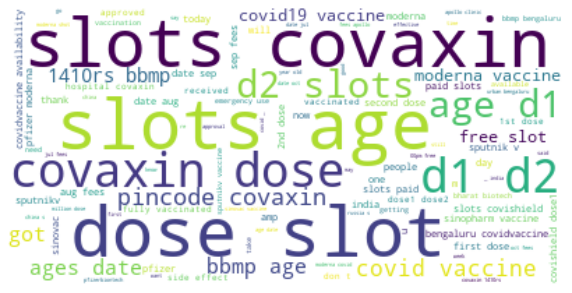

In [240]:
# Word Cloud
tweet_All = " ".join(review for review in tweet_labeled["text"])

fig, ax = plt.subplots(1, 1, figsize  = (10,10))
# Create and generate a word cloud image:
wordcloud_ALL = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(tweet_All)

# Display the generated image:
ax.imshow(wordcloud_ALL, interpolation='bilinear')

ax.axis('off')

0.04326697819443811
0.6796543617343279
0.16017281913283604


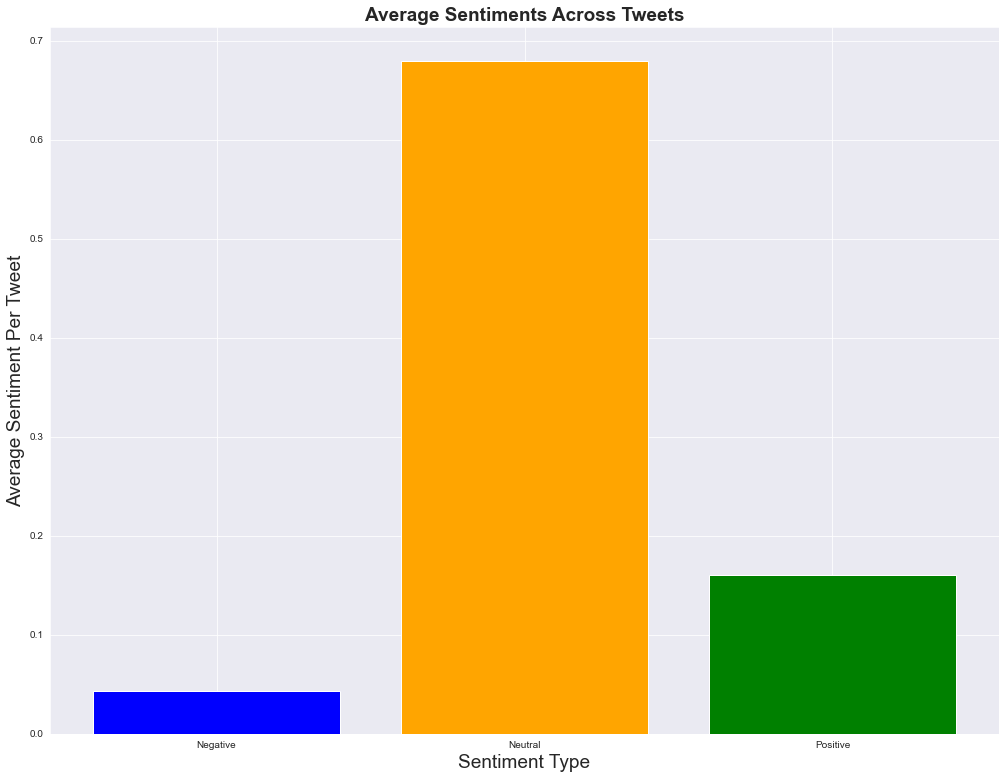

In [241]:
neg_prop = list(tweet_labeled["label"]).count(0)/tweet_labeled["label"].sum()
print(neg_prop)
neural_prop = list(tweet_labeled["label"]).count(1)/tweet_labeled["label"].sum()
print(neural_prop)
pos_prop = list(tweet_labeled["label"]).count(2)/tweet_labeled["label"].sum()
print(pos_prop)
sentiment_type = ['Negative','Neutral','Positive']
sentiment_total_avg = [neg_prop, neural_prop, pos_prop]
plt.title('Average Sentiments Across Tweets',fontsize=19,fontweight='bold')
plt.bar(sentiment_type, sentiment_total_avg, color = ['blue', 'orange', 'green'])
plt.ylabel('Average Sentiment Per Tweet',fontsize=19)
plt.xlabel('Sentiment Type',fontsize=19)
plt.show()

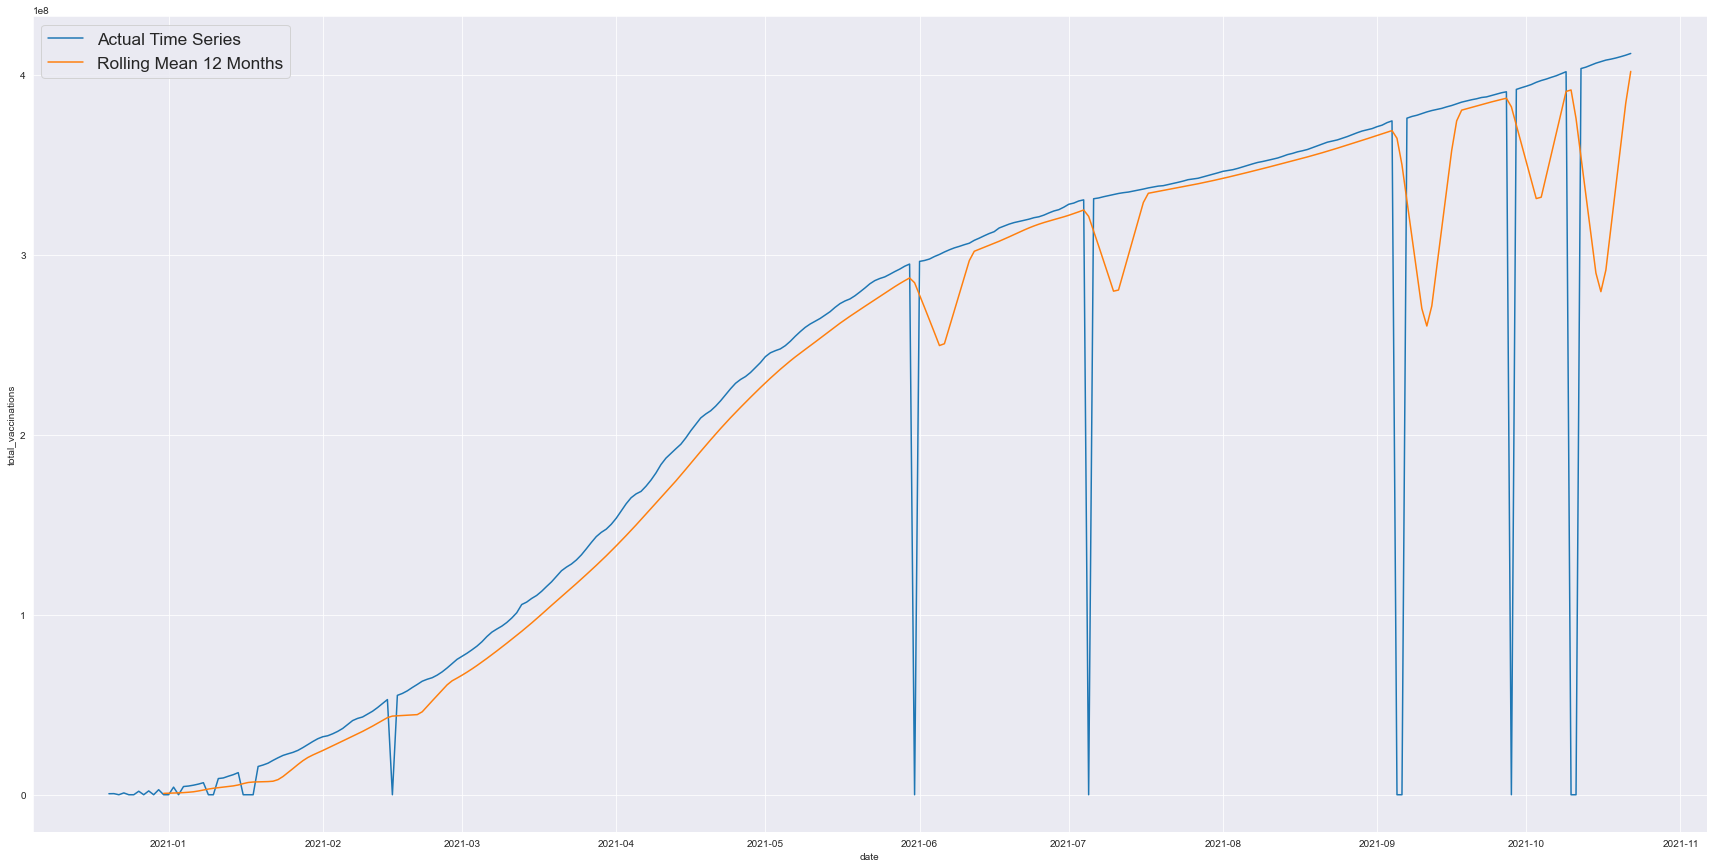

In [242]:
crossing1 = US[['date', 'total_vaccinations']].groupby('date').sum()
tseries = US.groupby(['date'])['total_vaccinations'].agg(
    ['sum']).reset_index().rename(columns={'sum': 'total_vaccinations'})

tseries = tseries.set_index('date')

fig = plt.subplots(figsize=(30, 15))

g = sns.lineplot(x=tseries.index, y='total_vaccinations',
                 data=tseries, label="Actual Time Series")

rmean = crossing1.rolling(12, win_type='triang').mean()

g = sns.lineplot(x=rmean.index, y='total_vaccinations',
                 data=rmean, label="Rolling Mean 12 Months")

plt.legend(fontsize='xx-large')
plt.show()

In [243]:
# Change variables
ft_data = tweet_labeled.copy()
ft_data['date'] = pd.to_datetime(tweet_labeled['date']).dt.date
ft_data['year'] = pd.DatetimeIndex(ft_data['date']).year
b_date_count = ft_data.groupby(by='date').count().reset_index()
b_date_count = b_date_count.rename(columns={'id':'Tweets Per Day'})
ft_data

,Unnamed: 0,Unnamed: 0.1,id,user_followers,date,text,hashtags,label,year
0,0,0,1340539111971516416,405,2020-12-20,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],1,2020
1,1,1,1338158543359250433,834,2020-12-13,while the world has been on the wrong side of ...,NaN,1,2020
2,2,2,1337858199140118533,10,2020-12-12,# coronavirus # sputnikv # astrazeneca # pfize...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",1,2020
3,3,3,1337855739918835717,49165,2020-12-12,"facts are immutable , senator , even when you ...",NaN,1,2020
4,4,4,1337854064604966912,152,2020-12-12,explain to me again why we need a vaccine @ bo...,"['whereareallthesickpeople', 'PfizerBioNTech']",1,2020
...,...,...,...,...,...,...,...,...,...
212977,212977,212977,1449266019286065158,3392,2021-10-16,18 - 44 # bbmp # bengaluru # covidvaccine avai...,"['BBMP', 'Bengaluru', 'CovidVaccine', 'COVISHI...",1,2021
212978,212978,212978,1449261432604815361,30,2021-10-16,18 - 44 # bbmp # bengaluru # covidvaccine avai...,"['BBMP', 'Bengaluru', 'CovidVaccine', 'COVISHI...",1,2021
212979,212979,212979,1449261398043811840,28,2021-10-16,"selling : # nitrilegloves , # 1860 # facemasks...","['NitrileGloves', 'FaceMasks', 'Vaccines', 'Sp...",1,2021
212980,212980,212980,1449261388422021120,30,2021-10-16,18 - 44 # urban # bengaluru # covidvaccine ava...,"['URBAN', 'Bengaluru', 'CovidVaccine', 'COVISH...",1,2021


In [244]:
fig = px.line(b_date_count,x='date',y='Tweets Per Day')
fig.update_traces(mode="markers+lines")
fig.update_layout(hovermode="x unified")

###annots
b_date_count.date = pd.to_datetime(b_date_count.date)
b_date_count_dt = b_date_count.set_index('date')

fig.add_annotation(x=datetime.datetime(2021,3,1), y=b_date_count_dt.loc[pd.Timestamp('2021-03-1'),'year'],
            text=r"J&J authorization",
            showarrow=True,
            arrowhead= 3,
            bordercolor="#c7c7c7")

fig.add_annotation(x=datetime.datetime(2021,4,21), y=b_date_count_dt.loc[pd.Timestamp('2021-04-21'),'year'],
            text=r"Fear of supply outstripping demand & CDC discussion of J&J bloodclots",
            showarrow=True,
            arrowhead=3,
            yshift=5,bordercolor="#c7c7c7")

fig.add_annotation(x=datetime.datetime(2021,6,29), y=b_date_count_dt.loc[pd.Timestamp('2021-06-29'),'year'],
            text=r"Discussion of vaccine protection against delta variant",
            showarrow=True,
            arrowhead=3,
            yshift=5,ay=-30,bordercolor="#c7c7c7")

fig.update_layout(title='<b>Daily Tweets<b>',width=1000)
fig.show()

In [245]:
neg_c = np.ones((len(b_date_count),1))
pos_c = np.zeros((len(b_date_count),1))
for i in range(len(b_date_count)):
    temp_pos = ft_data.loc[(ft_data['date'] == b_date_count['date'][i])]['label']
    pos_c[i] = temp_pos.value_counts()[2]/temp_pos.count()
neg_c -= pos_c
for i in range(len(b_date_count)):
    temp_neg = ft_data.loc[(ft_data['date'] == b_date_count['date'][i])]['label']
    neg_c[i] -= temp_neg.value_counts()[1]/temp_neg.count()
b_date_count = b_date_count.assign(neg_count=neg_c)
b_date_count = b_date_count.assign(pos_count=pos_c)
b_date_count

/Users/kerwin/miniforge3/envs/tf_m1/lib/python3.8/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



,date,Unnamed: 0,Unnamed: 0.1,Tweets Per Day,user_followers,text,hashtags,label,year,neg_count,pos_count
0,2020-12-12,63,63,63,63,63,48,63,63,0.031746,0.174603
1,2020-12-13,98,98,98,98,98,69,98,98,0.051020,0.163265
2,2020-12-14,137,137,137,137,137,104,137,137,0.007299,0.211679
3,2020-12-15,150,150,150,150,150,116,150,150,0.053333,0.200000
4,2020-12-16,144,144,144,144,144,95,144,144,0.097222,0.180556
...,...,...,...,...,...,...,...,...,...,...,...
287,2021-10-20,662,662,662,662,662,529,662,662,0.054381,0.114804
288,2021-10-21,1098,1098,1098,1098,1098,883,1098,1098,0.040984,0.166667
289,2021-10-22,727,727,727,727,727,573,727,727,0.045392,0.170564
290,2021-10-23,490,490,490,490,490,419,490,490,0.063265,0.200000


In [316]:
fig = px.line(b_date_count,x='date',y='neg_count')
fig.data[0].name="negtive proportion"
fig.add_scatter(x=b_date_count.date,y=b_date_count.pos_count,name="positive proportion")

###annots
b_date_count.date = pd.to_datetime(b_date_count.date)
b_date_count_neg = b_date_count.set_index('neg_count')


fig.add_annotation(x=datetime.datetime(2021,8,13), y=0.5014,
            text=r"an 89-year-old man died just days after receiving sinopharm vaccine",
            showarrow=True,
            arrowhead= 3,
            bordercolor="#c7c7c7")

fig.add_annotation(x=datetime.datetime(2021,1,17), y=0.2525,
            text=r"29 died within few days of covid19 vaccination",
            showarrow=True,
            arrowhead= 3,
            bordercolor="#c7c7c7")

fig.add_annotation(x=datetime.datetime(2021,3,3), y=0.4196,
            text=r"phase 3 results of covaxin demonstrates interim clinical efficacy of 81%",
            showarrow=True,
            arrowhead= 3,
            bordercolor="#c7c7c7")

fig.add_annotation(x=datetime.datetime(2021,10,12), y=0.2583,
            text=r"made in india vaccine is now available for kids",
            showarrow=True,
            arrowhead= 3,
            bordercolor="#c7c7c7")

fig.update_traces(mode="markers+lines",showlegend=True)
fig.update_layout(hovermode="x unified")
fig.update_layout(title='<b>Daily Negtive and Positive Sentiment<b>',width=1000)
fig.show()